# VARMA(p,q) and VARMAX can be used synonymously
## Vector Autoregressive Moving Average
This lesson picks up where VAR(p) left off.

Recall that the system of equations for a 2-dimensional VAR(1) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \varepsilon_{2,t}$

where the coefficient $\phi_{ii,l}$ captures the influence of the $l$th lag of variable $y_i$ on itself,<br>
the coefficient $\phi_{ij,l}$ captures the influence of the $l$th lag of variable $y_j$ on $y_i$.<br>
Most importantly, $\varepsilon_{1,t}$ and $\varepsilon_{2,t}$ are white noise processes that may be correlated.<br>

In a <strong>VARMA(p,q)</strong> model we give the error terms $\varepsilon_t$ a moving average representation of order $q$.


### Formulation
We've seen that an autoregressive moving average ARMA(p,q) model is described by the following:

&nbsp;&nbsp;&nbsp;&nbsp; $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \theta_{1}\varepsilon_{t-1} + \theta_{2}\varepsilon_{t-2} + \dots + \theta_{q}\varepsilon_{t-q} + \varepsilon_{t}$

A $K$-dimensional VARMA model of order $(p,q)$ considers each variable $y_K$ in the system.<br>

For example, the system of equations for a 2-dimensional VARMA(1,1) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \theta_{11,1}\varepsilon_{1,t-1} + \theta_{12,1}\varepsilon_{2,t-1} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \theta_{21,1}\varepsilon_{1,t-1} + \theta_{22,1}\varepsilon_{2,t-1} + \varepsilon_{2,t}$

where the coefficient $\theta_{ii,l}$ captures the influence of the $l$th lag of error $\varepsilon_i$ on itself,<br>
the coefficient $\theta_{ij,l}$ captures the influence of the $l$th lag of error $\varepsilon_j$ on $\varepsilon_i$,<br>
and $\varepsilon_{1,t}$ and $\varepsilon_{2,t}$ are residual white noise.<br>


The general steps involved in building a VARMA model are:
* Examine the data
* Visualize the data
* Test for stationarity
* If necessary, transform the data to make it stationary
* Select the appropriate <em>p</em> and <em>q</em> orders
* Instantiate the model and fit it to a training set
* If necessary, invert the earlier transformation
* Evaluate model predictions against a known test set
* Forecast the future

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.varmax.VARMAX.html'>
varmax.VARMAX</a></strong><font color=black>(endog[, exog, order, trend, …])</font>&nbsp;&nbsp;Vector Autoregressive Moving Average with eXogenous regressors model<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.varmax.VARMAXResults.html'>
varmax.VARMAXResults</a></strong><font color=black>(model, params[, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Class to hold results from fitting an VARMAX model<br>
</tt>
   
<h3>For Further Reading:</h3>
<strong>
<a href='https://www.statsmodels.org/stable/statespace.html#vector-autoregressive-moving-average-with-exogenous-regressors-varmax'>Statsmodels Tutorial:</a></strong>&nbsp;&nbsp;<font color=black>Time Series Analysis by State Space Methods</font><br>
<strong>
<a href='https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_varmax.html'>Statsmodels Example:</a></strong>&nbsp;&nbsp;<font color=black>VARMAX models</font><br>
</div>

### Perform standard imports and load dataset
For this analysis we'll reuse our money and spending datasets. We'll look at the M2 Money Stock which is a measure of U.S. personal assets, and U.S. personal spending. Both datasets are in billions of dollars, monthly, seasonally adjusted. They span the 21 years from January 1995 to December 2015 (252 records).<br>
Sources: https://fred.stlouisfed.org/series/M2SL https://fred.stlouisfed.org/series/PCE

In [126]:
import numpy as np
import pandas as pd
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df = pd.read_csv('../Data/M2SLMoneyStock.csv',index_col=0, 
                                             parse_dates=True)
df.index.freq = 'MS'

sp = pd.read_csv('../Data/PCEPersonalSpending.csv',index_col=0, 
                                                 parse_dates=True)
sp.index.freq = 'MS'

### Inspect the data

In [127]:
df = df.join(sp)
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [128]:
df = df.dropna()
df.shape

(252, 2)

### Plot the source data

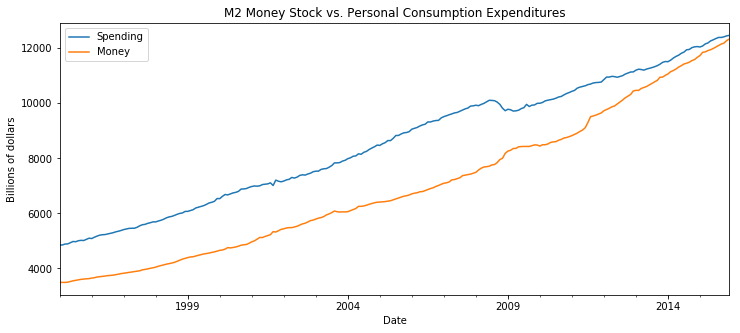

In [129]:
title = 'M2 Money Stock vs. Personal Consumption Expenditures'
ylabel='Billions of dollars'
xlabel=''

ax = df['Spending'].plot(figsize=(12,5),title=title,legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df['Money'].plot(legend=True);

## Test for stationarity, perform any necessary transformations
In the previous section we applied the augmented Dickey-Fuller test and found that a second-order difference achieved stationarity. In this section we'll perform the <strong>auto_arima</strong> prediction to identify optimal $p$ and $q$ orders. **Because auto_Arima can work with VARMA but NOT with VAR**

In [130]:
# INCLUDED HERE IF YOU CHOOSE TO USE IT
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

<div class="alert alert-info"><strong>NOTE: </strong> When performing the auto_arima function we're likely to see a <tt><font color=black>ConvergenceWarning: Maximum Likelihood optimization failed to converge.</font></tt> This is not unusual in models which have to estimate a large number of parameters. However, we can override the maximum iterations default of 50, and pass an arbitrarily large number with <tt>maxiter=1000</tt>. We'll see this come up again when we fit our model.</div>  

In [131]:
auto_arima(df['Money'],maxiter=1000)

ARIMA(maxiter=1000, method='lbfgs', order=(3, 2, 3), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [132]:
auto_arima(df['Spending'],maxiter=1000)

ARIMA(maxiter=1000, method='lbfgs', order=(1, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

#### Term p,d,q:  `money:(3, 2, 3)` and `Spending:(1, 1, 2)`
<br>


**1. Note that the $d$ term (2 for Money, 1 for Spending, in this case difference with the highest value i.e. 2) is about to be addressed by transforming the data to make it stationary.**
<br>


<br>

**2. For money, auto_arima suggests p=3 and q=3. For spending, auto_arima suggest p=1 and q=2. In this kind of case we should always take higher order of p and q.**

In [133]:
# difference twice
df_transformed = df.diff().diff()
df_transformed = df_transformed.dropna()
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [134]:
len(df_transformed)

250

## Train/test/split
It is useful to define a number of observations variable for our test set. For this analysis, let's use 12 months.

In [135]:
nobs=12
train,test = df_transformed[0:-nobs],df_transformed[-nobs:]

In [136]:
print(train.shape)
print(test.shape)

(238, 2)
(12, 2)


## Fit the VARMA(3,3) Model
This may take awhile.

In [137]:
# trend='c' is default means constant_linear_trend
model = VARMAX(train, order=(3,3), trend='c')

# disp=False is like verbose of scikit_learn
results = model.fit(maxiter=1000, disp=False)
results.summary()

Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(3,3)",Log Likelihood,-2270.316
,+ intercept,AIC,4598.631
Date:,"Wed, 03 Jun 2020",BIC,4699.327
Time:,19:51:07,HQIC,4639.213
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (Q):,"45.05, 28.91",Jarque-Bera (JB):,"605.57, 132.83"
Prob(Q):,"0.27, 0.90",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"6.22, 2.74",Skew:,"1.35, -0.43"


## Predict the next 12 values
Unlike the VAR model we used in the previous section, the VARMAX <tt>.forecast()</tt> function won't require that we pass in a number of previous observations, and it will provide an extended DateTime index.

In [138]:
df_forecast = results.forecast(12)
df_forecast

,Money,Spending
2015-01-01,-13.141801,34.336095
2015-02-01,-1.376637,-5.701545
2015-03-01,1.508859,-1.773214
2015-04-01,-8.903177,0.786351
2015-05-01,6.314497,3.996064
2015-06-01,-1.818129,-4.180621
2015-07-01,-2.861149,3.137027
2015-08-01,3.775751,0.040926
2015-09-01,-1.878504,-1.514557
2015-10-01,-0.448846,1.845112


This is much simpler than what we had to do for VAR model.

## Invert the Transformation
Remember that the forecasted values represent second-order differences. To compare them to the original data we have to roll back each difference. To roll back a first-order difference we take the most recent value on the training side of the original series, and add it to a cumulative sum of forecasted values. When working with second-order differences we first must perform this operation on the most recent first-order difference.

Here we'll use the <tt>nobs</tt> variable we defined during the train/test/split step.

In [139]:
# Add the most recent first difference from the training side
# of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-\
                          df['Money'].iloc[-nobs-2]) + \
                                df_forecast['Money'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + \
                                    df_forecast['Money1d'].cumsum()

In [140]:
# Add the most recent first difference from the training side 
# of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-\
                             df['Spending'].iloc[-nobs-2]) +\
                                df_forecast['Spending'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] +\
                                    df_forecast['Spending1d'].cumsum()

In [141]:
df_forecast

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-13.141801,34.336095,65.458199,11735.558199,44.936095,12106.936095
2015-02-01,-1.376637,-5.701545,64.081562,11799.639762,39.234550,12146.170645
2015-03-01,1.508859,-1.773214,65.590421,11865.230183,37.461336,12183.631981
2015-04-01,-8.903177,0.786351,56.687244,11921.917427,38.247687,12221.879667
2015-05-01,6.314497,3.996064,63.001741,11984.919169,42.243750,12264.123418
2015-06-01,-1.818129,-4.180621,61.183613,12046.102781,38.063129,12302.186547
2015-07-01,-2.861149,3.137027,58.322463,12104.425245,41.200157,12343.386704
2015-08-01,3.775751,0.040926,62.098214,12166.523459,41.241082,12384.627786
2015-09-01,-1.878504,-1.514557,60.219711,12226.743169,39.726525,12424.354312
2015-10-01,-0.448846,1.845112,59.770864,12286.514033,41.571637,12465.925949


In [142]:
pd.concat([df.iloc[-12:],df_forecast[['MoneyForecast',
                            'SpendingForecast']]],axis=1)

,Money,Spending,MoneyForecast,SpendingForecast
Date,,,,
2015-01-01,11733.2,12046.0,11735.558199,12106.936095
2015-02-01,11852.4,12082.4,11799.639762,12146.170645
2015-03-01,11868.8,12158.3,11865.230183,12183.631981
2015-04-01,11916.1,12193.8,11921.917427,12221.879667
2015-05-01,11947.6,12268.1,11984.919169,12264.123418
2015-06-01,11993.1,12308.3,12046.102781,12302.186547
2015-07-01,12045.3,12355.4,12104.425245,12343.386704
2015-08-01,12096.8,12394.0,12166.523459,12384.627786
2015-09-01,12153.8,12392.8,12226.743169,12424.354312


## Plot the results

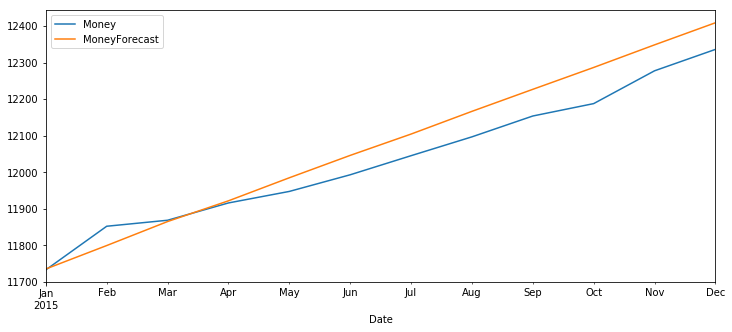

In [143]:
df['Money'][-nobs:].plot(figsize=(12,5),legend=True).\
                            autoscale(axis='x',tight=True)
df_forecast['MoneyForecast'].plot(legend=True);

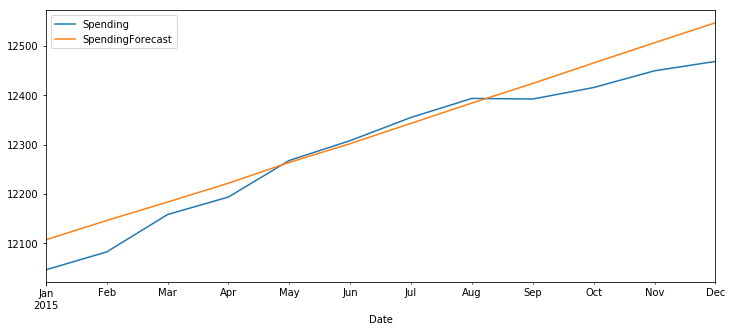

In [144]:
df['Spending'][-nobs:].plot(figsize=(12,5),legend=True).\
                                autoscale(axis='x',tight=True)
df_forecast['SpendingForecast'].plot(legend=True);

**Prediction using VARMA model looks terrible. Let's check this quantitatively.**

### Evaluate the model

&nbsp;&nbsp;&nbsp;&nbsp;$RMSE = \sqrt{{\frac 1 L} \sum\limits_{l=1}^L (y_{T+l} - \hat y_{T+l})^2}$<br><br>
where $T$ is the last observation period and $l$ is the lag.

In [145]:
RMSE1 = rmse(df['Money'][-nobs:],df_forecast['MoneyForecast'])
print(f'Money VAR(5) RMSE: {RMSE1:.3f}')

Money VAR(5) RMSE: 58.320


In [146]:
df['Money'][-nobs:].mean()

12034.008333333333

In [147]:
RMSE2 = rmse(df['Spending'][-nobs:], df_forecast['SpendingForecast'])
print(f'Spending VAR(5) RMSE: {RMSE2:.3f}')

Spending VAR(5) RMSE: 43.177


In [148]:
df['Spending'][-nobs:].mean()

12294.533333333333

Clearly these results are less accurate than our earlier VAR(5) model. Still, this tells us something!
## Let's compare these results to individual ARMA(3,3) models

In [149]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults

### Money

In [150]:
# Auto_arima suggested for money p,d,q:(3, 2, 3)
model = ARMA(train['Money'],order=(3,3))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Money   No. Observations:                  238
Model:                     ARMA(3, 3)   Log Likelihood               -1108.971
Method:                       css-mle   S.D. of innovations             25.055
Date:                Wed, 03 Jun 2020   AIC                           2233.942
Time:                        19:53:34   BIC                           2261.720
Sample:                    03-01-1995   HQIC                          2245.137
                         - 12-01-2014                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1824      0.034      5.323      0.000       0.115       0.250
ar.L1.Money    -0.7969      0.063    -12.706      0.000      -0.920      -0.674
ar.L2.Money    -0.6313      0.070     -9.021      0.000      -0.768      -0.494
ar.L3.Money     0.3185      0.062      5.144      0.000       0.197       0.440
ma.L1.Money     0.0944        nan        nan        nan         nan         nan
ma.L2.Money    -0.0944      0.007    -13.752      0.000      -0.108      -0.081
ma.L3.Money    -1.0000        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5644           -0.8311j            1.0046           -0.3449
AR.2           -0.5644           +0.8311j            1.0046            0.3449
AR.3            3.1109           -0.0000j            3.1109           -0.0000
MA.1           -0.5472           -0.8370j            1.0000           -0.3422
MA.2           -0.5472           +0.8370j            1.0000            0.3422
MA.3            1.0000           -0.0000j            1.0000           -0.0000
-----------------------------------------------------------------------------
"""

In [151]:
start=len(train)
end=len(train)+len(test)-1
z1 = results.predict(start=start, end=end).rename('Money')
z1 = pd.DataFrame(z1)

In [152]:
z1

,Money
2015-01-01,-19.929992
2015-02-01,-3.024346
2015-03-01,6.622437
2015-04-01,-9.330828
2015-05-01,2.676136
2015-06-01,6.252096
2015-07-01,-9.258710
2015-08-01,4.668051
2015-09-01,4.501311
2015-10-01,-9.098112


### Invert the Transformation, Evaluate the Forecast

In [153]:
# Add the most recent first difference from the 
# training set to the forecast cumulative sum
z1['Money1d'] = (df['Money'].iloc[-nobs-1]-\
    df['Money'].iloc[-nobs-2]) + z1['Money'].cumsum()

# Now build the forecast values from the first difference set
z1['MoneyForecast'] = df['Money'].iloc[-nobs-1] +\
                                z1['Money1d'].cumsum()

In [154]:
z1

,Money,Money1d,MoneyForecast
2015-01-01,-19.929992,58.670008,11728.770008
2015-02-01,-3.024346,55.645662,11784.415669
2015-03-01,6.622437,62.268098,11846.683768
2015-04-01,-9.330828,52.937270,11899.621038
2015-05-01,2.676136,55.613406,11955.234443
2015-06-01,6.252096,61.865501,12017.099945
2015-07-01,-9.258710,52.606791,12069.706736
2015-08-01,4.668051,57.274843,12126.981579
2015-09-01,4.501311,61.776154,12188.757733
2015-10-01,-9.098112,52.678042,12241.435775


In [155]:
RMSE3 = rmse(df['Money'][-nobs:], z1['MoneyForecast'])

print(f'Money VARMA(1,2) RMSE: {RMSE1:.3f}')
print(f'Money  ARMA(1,2) RMSE: {RMSE3:.3f}')

Money VARMA(1,2) RMSE: 58.320
Money  ARMA(1,2) RMSE: 32.734


## Personal Spending

In [156]:
# auto_arima suggested for Spending:(1, 1, 2)
model = ARMA(train['Spending'],order=(1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               Spending   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1182.411
Method:                       css-mle   S.D. of innovations             34.661
Date:                Wed, 03 Jun 2020   AIC                           2374.823
Time:                        19:57:52   BIC                           2392.184
Sample:                    03-01-1995   HQIC                          2381.820
                         - 12-01-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0856      0.245      0.350      0.726      -0.394       0.565
ar.L1.Spending    -0.3403      0.511     -0.666      0.505      -1.342       0.661
ma.L1.Spending    -0.6451      0.521     -1.237      0.216      -1.667       0.377
ma.L2.Spending    -0.2139      0.485     -0.441      0.659      -1.165       0.737
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.9388           +0.0000j            2.9388            0.5000
MA.1            1.1281           +0.0000j            1.1281            0.0000
MA.2           -4.1439           +0.0000j            4.1439            0.5000
-----------------------------------------------------------------------------
"""

In [157]:
start=len(train)
end=len(train)+len(test)-1
z2 = results.predict(start=start, end=end).rename('Spending')
z2 = pd.DataFrame(z2)
z2

,Spending
2015-01-01,33.555876
2015-02-01,-3.338291
2015-03-01,1.250703
2015-04-01,-0.310826
2015-05-01,0.220526
2015-06-01,0.039719
2015-07-01,0.101244
2015-08-01,0.080308
2015-09-01,0.087432
2015-10-01,0.085008


### Invert the Transformation, Evaluate the Forecast

In [158]:
# Add the most recent first difference from the 
# training set to the forecast cumulative sum
z2['Spending1d'] = (df['Spending'].iloc[-nobs-1]-\
    df['Spending'].iloc[-nobs-2]) + z2['Spending'].cumsum()

# Now build the forecast values from the first difference set
z2['SpendingForecast'] = df['Spending'].iloc[-nobs-1] +\
                                    z2['Spending1d'].cumsum()

In [159]:
z2

,Spending,Spending1d,SpendingForecast
2015-01-01,33.555876,44.155876,12106.155876
2015-02-01,-3.338291,40.817585,12146.973460
2015-03-01,1.250703,42.068288,12189.041748
2015-04-01,-0.310826,41.757462,12230.799210
2015-05-01,0.220526,41.977988,12272.777198
2015-06-01,0.039719,42.017707,12314.794905
2015-07-01,0.101244,42.118951,12356.913856
2015-08-01,0.080308,42.199260,12399.113116
2015-09-01,0.087432,42.286692,12441.399808
2015-10-01,0.085008,42.371700,12483.771508


In [160]:
RMSE4 = rmse(df['Spending'][-nobs:], z2['SpendingForecast'])

print(f'Spending VARMA(1,2) RMSE: {RMSE2:.3f}')
print(f'Spending  ARMA(1,2) RMSE: {RMSE4:.3f}')

Spending VARMA(1,2) RMSE: 43.177
Spending  ARMA(1,2) RMSE: 52.334


<strong>CONCLUSION:</strong> It looks like the VARMA(3,3) model did a almost similar job compared to simpler alternatives. **This tells us that there MAY be an interdependence between Money Stock and Personal Consumption Expenditures, at least for the timespan we investigated.** 

### Results do NOT clearly suggest enough interaction between Money Stock and Personal Consumption Expenditures to warrant vector component. So maybe using ARIMA model makes more sense when VARMAX fit more terribly. 

### This is a decent fit for VARMAX and in VARMAX benefit is we will have 1 model for 2 series and that is great.

# But for ARIMA we will have 1 model per feature (or time-series), using VARMAX we can have 1 model for multiple features
